# Reading the dataset

## D1: Exploratory data analysis and preprocessing.
### (a) Plot the histograms of the non-categorical features and the target in a grid subplot using the histplot function from the seaborn with the default values.


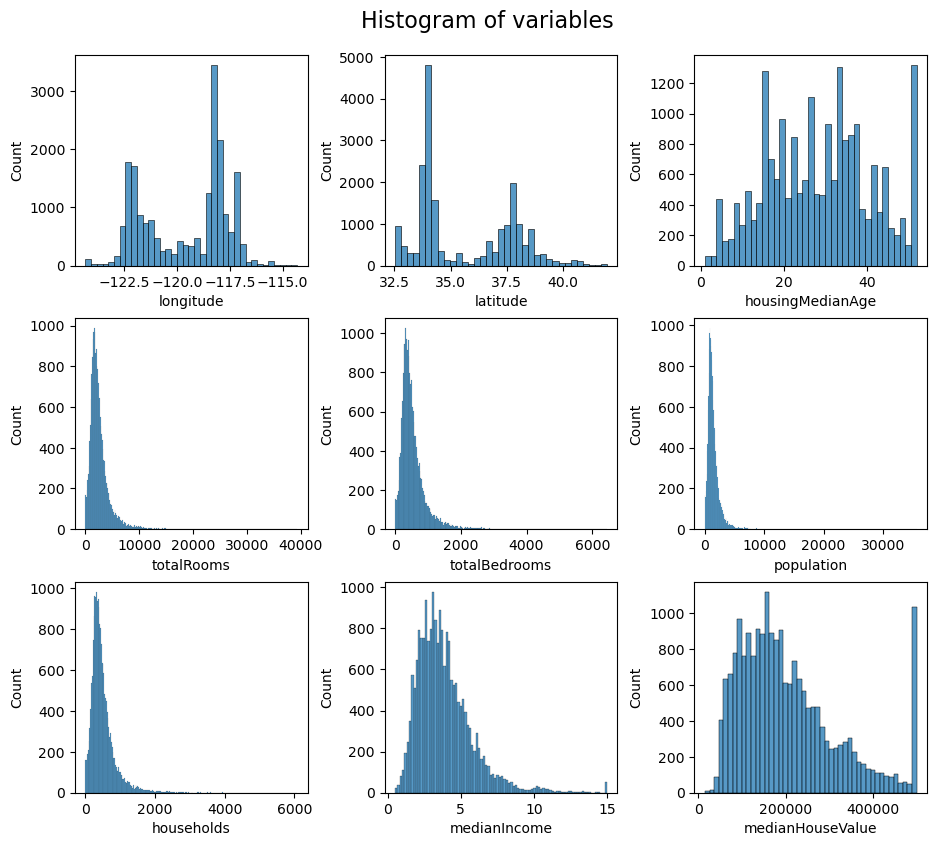

In [1]:
from seaborn import histplot
import matplotlib.pyplot as plt
import pandas as pd

data0 = pd.read_csv("dataset/housingCalifornia.csv")

fig, axs = plt.subplots(3, 3, figsize=(11, 9))
fig.suptitle("Histogram of variables", fontsize=16)
plt.subplots_adjust(wspace=0.33, hspace=0.25, top=0.93)

for i, ax in enumerate(axs.flat):
    histplot(data0.drop(columns="oceanProximity").iloc[:, i], ax=ax)

Looking at the data, we are able to notice that there is a distinct peak to the right of both medianHouseValue and housingMedianAge. This could arise from a truncation when counting. Moreover, the distribution of the data is generally right-skewed.

### (b) Compute the correlation matrix of all features (including the target features). Do not use the categorical variable (ocean proximity). Describe which features are more correlated (correlation coefficient higher than 0.8 in magnitude) and why you think this is the case.


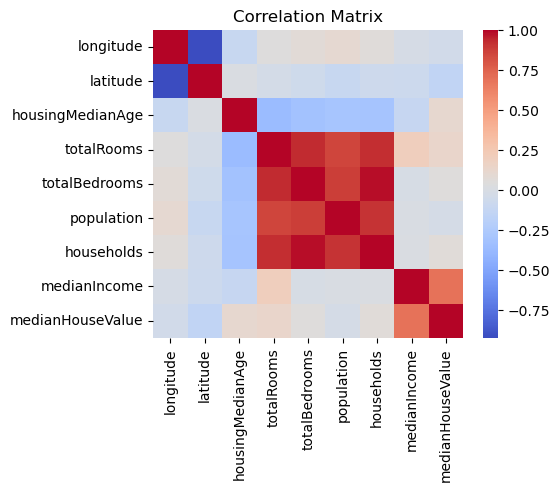

In [2]:
from seaborn import heatmap

plt.figure(figsize=(5, 4))
heatmap(data0.drop(columns="oceanProximity").corr(), cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The highest correlation is observed between 'totalBedrooms' and 'households', as more bedrooms allow accommodating more people. Another highly correlated pair is 'totalRooms' and 'totalBedrooms', likely due to a consistent bedroom-to-room ratio in residential properties.

### (c) Present a scatter plot for each variable, displaying the corresponding variable on the x-axis and the target variable on the y-axis.

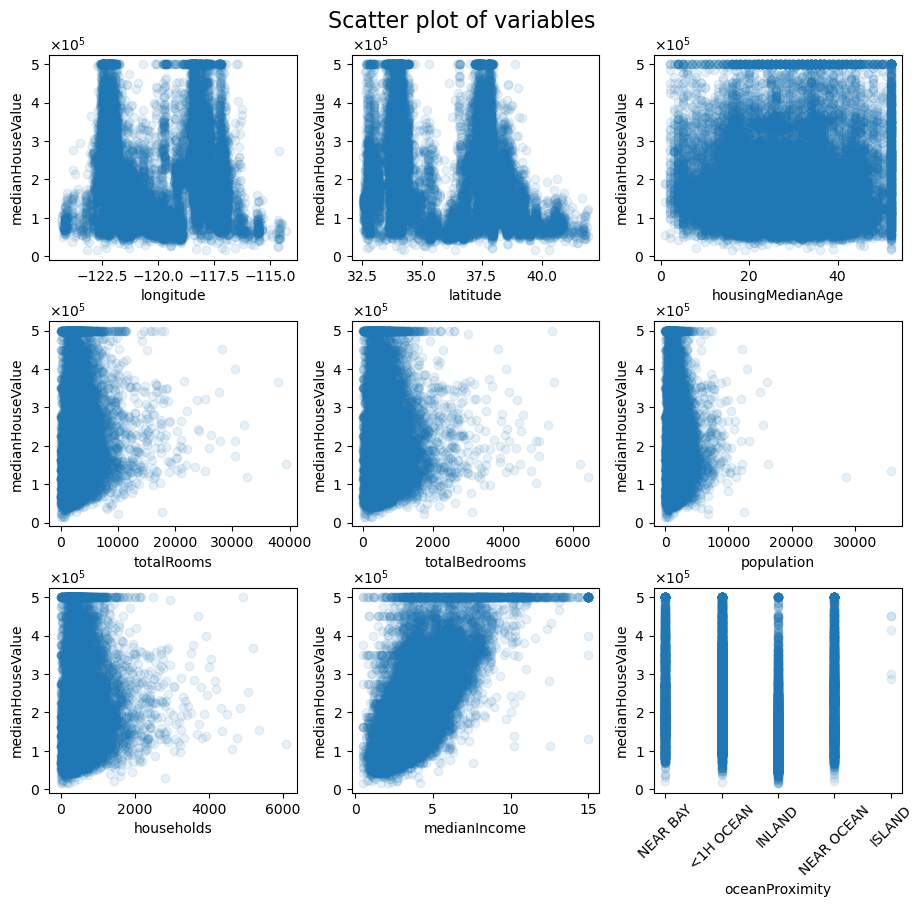

In [3]:
import matplotlib.ticker as ticker

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 4))

fig, axs = plt.subplots(3, 3, figsize=(11, 9))
fig.suptitle("Scatter plot of variables", fontsize=16)
plt.subplots_adjust(wspace=0.22, hspace=0.3, top=0.93)

for i, ax in enumerate(axs.flat):
    ax.scatter(data0.iloc[:, i], data0["medianHouseValue"], alpha=0.1)
    ax.set_xlabel(data0.columns[i])
    ax.set_ylabel("medianHouseValue")
    ax.yaxis.set_major_formatter(formatter)

    if i == 8:
        ax.xaxis.set_tick_params(rotation=45)

As shown by the correlation matrix, most features have a weak linear relationship with the target variable. Among the features, 'medianIncome' has the strongest linear relationship with 'medianHouseValue'.

# Analysing the impact of different data transformations.

Create two versions of the dataset as described below. Remember to properly encode the categorical variable by creating l−1 new binary/dummy variables, where l is the number of categories of the variable. Use “<1H OCEAN” as a reference (you should not add a dummy variable for this category).

## D2: Split each of these two datasets into training and test sets, using 80% of the data for training (use the Python train test split function).

Remember to set the random generator’s state to the value “5508” for the splitting function. Fit two models in each dataset: a linear regression model and a Lasso regression model with α = 100. Standardised both datasets appropriately (transforming the features to have zero mean and unit standard deviation). Thus, you provide results for the original and standardised version of data1) and for the original and standardised version of data2).

Following the instructions, we create two dataset with spliting.

In [4]:
from sklearn.model_selection import train_test_split

data1 = pd.get_dummies(
    data0,
    columns=["oceanProximity"],
    drop_first=True,
    dtype=int,
    prefix="",
    prefix_sep="",  # Remove the prefix part since we only have one categorical variable
)

data2 = data1.copy()
data2["medianHouseValue"] = data1["medianHouseValue"] * 1e-5

RANDOM_SEED = 5508

(
    train_data1,
    test_data1,
    train_target1,
    test_target1,
) = train_test_split(
    data1.drop(columns="medianHouseValue"),
    data1["medianHouseValue"],
    train_size=0.8,
    random_state=RANDOM_SEED,
)

(
    train_data2,
    test_data2,
    train_target2,
    test_target2,
) = train_test_split(
    data2.drop(columns="medianHouseValue"),
    data2["medianHouseValue"],
    train_size=0.8,
    random_state=RANDOM_SEED,
)

### (a) In a table, report the RMSE for the training and test sets for the two models for each dataset. That is, your table should contain four rows with four values each.

In [45]:
from sklearn.preprocessing import StandardScaler
from IPython.display import Markdown, display
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso


def print_df(df):
    """
    Print DataFrame in a markdown format
    """
    display(Markdown(df.to_markdown()))
    display()


def print_markdown(text):
    """
    Print text in a markdown format
    """
    display(Markdown(text))


def train_process(train_data, test_data, train_target, test_target):
    """
    Train the model and return the RMSE of the train and test data
    """
    lr = LinearRegression()
    lr.fit(train_data, train_target)
    lr_train_rmse = root_mean_squared_error(train_target, lr.predict(train_data))
    lr_test_rmse = root_mean_squared_error(test_target, lr.predict(test_data))
    lr_params = [*lr.coef_, lr.intercept_]

    ls = Lasso(alpha=100, random_state=RANDOM_SEED)
    ls.fit(train_data, train_target)
    ls_train_rmse = root_mean_squared_error(train_target, ls.predict(train_data))
    ls_test_rmse = root_mean_squared_error(test_target, ls.predict(test_data))
    ls_params = [*ls.coef_, ls.intercept_]

    return {
        "LR Train RMSE": lr_train_rmse,
        "LR Test RMSE": lr_test_rmse,
        "Lasso Train RMSE": ls_train_rmse,
        "Lasso Test RMSE": ls_test_rmse,
        "LR_params": lr_params,
        "Lasso_params": ls_params,
    }


scaler1 = StandardScaler()
scaler2 = StandardScaler()

train_data1_scaled = scaler1.fit_transform(train_data1)
train_data2_scaled = scaler2.fit_transform(train_data2)

test_data1_scaled = scaler1.transform(test_data1)
test_data2_scaled = scaler2.transform(test_data2)

d2_result = []
for d in [
    (train_data1, test_data1, train_target1, test_target1),
    (train_data1_scaled, test_data1_scaled, train_target1, test_target1),
    (train_data2, test_data2, train_target2, test_target2),
    (train_data2_scaled, test_data2_scaled, train_target2, test_target2),
]:
    d2_result.append(train_process(*d))

print_markdown("**RMSE Result on data1 and data2 (Std means Standardise):**")
print_df(
    pd.DataFrame(
        d2_result,
        columns=[
            "LR Train RMSE",
            "LR Test RMSE",
            "Lasso Train RMSE",
            "Lasso Test RMSE",
        ],
        index=[
            "data1",
            "Std data1",
            "data2",
            "Std data2",
        ],
    )
)

**RMSE Result on data1 and data2 (Std means Standardise):**

|           |   LR Train RMSE |   LR Test RMSE |   Lasso Train RMSE |   Lasso Test RMSE |
|:----------|----------------:|---------------:|-------------------:|------------------:|
| data1     |    68607.3      |   68589.3      |         68660.5    |       68601.8     |
| Std data1 |    68607.3      |   68589.3      |         68615.4    |       68623.4     |
| data2     |        0.686073 |       0.685893 |             1.1294 |           1.11976 |
| Std data2 |        0.686073 |       0.685893 |             1.1563 |           1.14438 |

### (b) Discuss the RMSE values obtained results. Specifically, discuss if they have the same values and why and if they have different values and why.

Observing the results, we can notice that in the Linear Regression model, the RMSE of the models trained on both datasets only differs by several orders of magnitude, which corresponds to the transformation applied earlier. Additionally, standardizing the datasets did not have an impact on the results. However, in the Lasso Regression model, we can observe significant numerical differences between the two datasets, and standardization also affected the results.

\begin{align}
&\text{Lasso objective:}&& \frac{1}{2 \cdot n_{\text{samples}}} \cdot \lVert y - Xw \rVert^2_2 + \alpha \cdot \lVert w \rVert_1
\end{align}

The reason for the different numerical results in the Lasso Regression model for the two datasets lies in the inclusion of an L1 regularization term in the model's optimization objective. Since we fixed the value of alpha, the influence of the L1 regularization term changes after scaling the target variable. In Data2, scaling the target variable increased the influence of the L1 regularization term, resulting in poorer fitting of the Lasso Regression model to the results in Data2.

Similarly, after standardizing the features, scaling the feature variables changed the influence of the L1 regularization term. However, in the Linear Regression model without regularization, standardizing the features did not affect the results.

## D3 Create three new features (meanRooms, meanBedrooms, and meanOccupation) as follows:

- meanRooms = total rooms / households. It represents the mean number of rooms per household.
- meanBedrooms = total bedrooms / households. It represents the mean number of bedrooms per household.
- meanOcupation = population / households. It represents the mean number of household members.

### (a) Report the RMSE for the two models’ training and test sets in a table. Your table should 4 marks contain two rows with four values each

In [6]:
# As instruction, we create data3
data3 = data2.drop(columns=["totalRooms", "totalBedrooms", "population", "households"])
data3["medianRooms"] = data2["totalRooms"] / data2["households"]
data3["medianBedrooms"] = data2["totalBedrooms"] / data2["households"]
data3["populationPerHousehold"] = data2["population"] / data2["households"]

In [46]:
train_data3, test_data3, train_target3, test_target3 = train_test_split(
    data3.drop(columns="medianHouseValue"),
    data3["medianHouseValue"],
    train_size=0.8,
    random_state=RANDOM_SEED,
)

scaler3 = StandardScaler()
train_data3_scaled = scaler3.fit_transform(train_data3)
test_data3_scaled = scaler3.transform(test_data3)

d3_result = []
for d in [
    (train_data3, test_data3, train_target3, test_target3),
    (train_data3_scaled, test_data3_scaled, train_target3, test_target3),
]:
    d3_result.append(train_process(*d))

print_markdown("**RMSE Result on data3 and data3 (Std means Standardise):**")
print_df(
    pd.DataFrame(
        d3_result,
        columns=[
            "LR Train RMSE",
            "LR Test RMSE",
            "Lasso Train RMSE",
            "Lasso Test RMSE",
        ],
        index=[
            "data3",
            "Std data3",
        ],
    )
)

**RMSE Result on data3 and data3 (Std means Standardise):**

|           |   LR Train RMSE |   LR Test RMSE |   Lasso Train RMSE |   Lasso Test RMSE |
|:----------|----------------:|---------------:|-------------------:|------------------:|
| data3     |         0.70949 |        1.13601 |             1.1563 |           1.14438 |
| Std data3 |         0.70949 |        1.13601 |             1.1563 |           1.14438 |

### (b) Discuss and justify the obtained values of RMSE.

Comparing data3 result to data2 result, we can notice the LR Test RMSE of data3 is significantly higher than data2. That means after modifying the dataset, the model gets less information from the data, which results in a higher RMSE.

The large LR Test RMSE of data3 implies that linear regression is underfitting the data, it can't capture the underlying pattern of the data3.

The other thing we can notice is that standardizing the dataset didn't impact the results on Lasso model, which is different from the previous results. Base on the poor results of the Lasso model, we can guess that's because Lasso is highly underfitting on data3.

In [8]:
print(f"data3 coefficients: {d3_result[0]["Lasso_params"]}")
print(f"std data3 coefficients: {d3_result[1]['Lasso_params']}")

data3 coefficients: [-0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 2.067789048570737]
std data3 coefficients: [-0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 2.067789048570737]


After check, we can confirm our guess, we can see all the coefficients (except intercept) of the Lasso model are zero, which means the model is not learning anything from the data. The main reason for this is the too high alpha value.

### (c) Report the estimated parameter values with the corresponding variable names for all models (12 in total, eight from D2 and four from D3).

In [9]:
import numpy as np

d2_params = []

for d in d2_result:
    d2_params.append(d["LR_params"])
    d2_params.append(d["Lasso_params"])

d3_params = []

for d in d3_result:
    d3_params.append(d["LR_params"])
    d3_params.append(d["Lasso_params"])


def print_long_table(data, columns, index, max_col):
    for i in range(0, data.shape[1], max_col):
        print_df(
            pd.DataFrame(
                data[:, i : i + max_col], columns=columns[i : i + max_col], index=index
            )
        )


print_markdown("**Parameters of the D2 models:**")

print_long_table(
    np.array(d2_params),
    columns=[
        *data2.drop(columns="medianHouseValue"),
        "Intercept",
    ],
    index=[
        "data1 LR",
        "data1 Lasso",
        "Std data1 LR",
        "Std data1 Lasso",
        "data2 LR",
        "data2 Lasso",
        "Std data2 LR",
        "Std data2 Lasso",
    ],
    max_col=5,
)

print_markdown("**Parameters of the D3 models:**")

print_long_table(
    np.array(d3_params),
    columns=[
        *data3.drop(columns="medianHouseValue"),
        "Intercept",
    ],
    index=[
        "data3 LR",
        "data3 Lasso",
        "Std data3 LR",
        "Std data3 Lasso",
    ],
    max_col=5,
)

**Parameters of the D2 models:**

|                 |     longitude |      latitude |   housingMedianAge |       totalRooms |   totalBedrooms |
|:----------------|--------------:|--------------:|-------------------:|-----------------:|----------------:|
| data1 LR        | -26533.2      | -25444.9      |        1055.9      |     -6.42899     |    102.936      |
| data1 Lasso     | -26398.8      | -25420.8      |        1059.84     |     -6.43366     |    103.358      |
| Std data1 LR    | -53194.9      | -54426.5      |       13309.9      | -14090.6         |  43350.1        |
| Std data1 Lasso | -50311.5      | -51488.5      |       13258.9      | -12015.2         |  41169.6        |
| data2 LR        |     -0.265332 |     -0.254449 |           0.010559 |     -6.42899e-05 |      0.00102936 |
| data2 Lasso     |     -0        |     -0        |           0        |      0.000103676 |     -0          |
| Std data2 LR    |     -0.531949 |     -0.544265 |           0.133099 |     -0.140906    |      0.433501   |
| Std data2 Lasso |     -0        |     -0        |           0        |      0           |      0          |

|                 |       population |      households |   medianIncome |        INLAND |         ISLAND |
|:----------------|-----------------:|----------------:|---------------:|--------------:|---------------:|
| data1 LR        |    -36.3516      |    45.1305      |   39305.2      | -39134.8      | 153586         |
| data1 Lasso     |    -36.4043      |    44.8074      |   39291.4      | -38755        |      0         |
| Std data1 LR    | -41771.5         | 17290.2         |   74889.2      | -18231.7      |   2672.21      |
| Std data1 Lasso | -41042.2         | 16763.8         |   74413        | -19118.8      |   2593.78      |
| data2 LR        |     -0.000363516 |     0.000451305 |       0.393052 |     -0.391348 |      1.53586   |
| data2 Lasso     |     -0.000117619 |    -0           |       0        |     -0        |      0         |
| Std data2 LR    |     -0.417715    |     0.172902    |       0.748892 |     -0.182317 |      0.0267221 |
| Std data2 Lasso |     -0           |     0           |       0        |     -0        |      0         |

|                 |      NEAR BAY |   NEAR OCEAN |        Intercept |
|:----------------|--------------:|-------------:|-----------------:|
| data1 LR        | -791.47       | 4935.32      |     -2.23866e+06 |
| data1 Lasso     |   -0          | 4206.63      |     -2.22355e+06 |
| Std data1 LR    | -247.444      | 1648.33      | 206779           |
| Std data1 Lasso |   -0          | 1736.25      | 206779           |
| data2 LR        |   -0.0079147  |    0.0493532 |    -22.3866      |
| data2 Lasso     |    0          |    0         |      1.96253     |
| Std data2 LR    |   -0.00247444 |    0.0164833 |      2.06779     |
| Std data2 Lasso |    0          |    0         |      2.06779     |

**Parameters of the D3 models:**

|                 |   longitude |   latitude |   housingMedianAge |   medianIncome |    INLAND |
|:----------------|------------:|-----------:|-------------------:|---------------:|----------:|
| data3 LR        |   -0.26144  |  -0.248051 |         0.00840887 |       0.417373 | -0.381382 |
| data3 Lasso     |   -0        |  -0        |         0          |       0        | -0        |
| Std data3 LR    |   -0.524144 |  -0.53058  |         0.105996   |       0.795231 | -0.177674 |
| Std data3 Lasso |   -0        |  -0        |         0          |       0        | -0        |

|                 |    ISLAND |   NEAR BAY |   NEAR OCEAN |   medianRooms |   medianBedrooms |
|:----------------|----------:|-----------:|-------------:|--------------:|-----------------:|
| data3 LR        | 1.52674   |  0.0586893 |    0.0838804 |    -0.0801149 |         0.490103 |
| data3 Lasso     | 0         |  0         |    0         |     0         |        -0        |
| Std data3 LR    | 0.0265635 |  0.0183486 |    0.0280149 |    -0.201913  |         0.239342 |
| Std data3 Lasso | 0         |  0         |    0         |     0         |        -0        |

|                 |   populationPerHousehold |   Intercept |
|:----------------|-------------------------:|------------:|
| data3 LR        |               -0.0408616 |   -22.0876  |
| data3 Lasso     |               -0         |     2.06779 |
| Std data3 LR    |               -0.0875644 |     2.06779 |
| Std data3 Lasso |               -0         |     2.06779 |

### (d) Discuss the obtained results. Are there similarities with the parameters’ values from each model? Justify your answer.

In line with the findings from D2(b), **in the LR model**, regardless of whether the dataset is standardized or not, the coefficients for data1 and data2 differ only by several orders of magnitude. However, due to the alterations made to data3, the coefficients in the LR model for data3 differ from those of data1 and data2.

**In the Lasso model**, the coefficients for data2 and data3 models are small, resulting in them being significantly constrained by the L1 regularization term. Consequently, this heavy restriction leads to underfitting in both the data2 and data3 Lasso models, resulting in poor performance.

# Analysing the impact of different models
## D4: Consider data3, using the 80%-20% splitting of the data and the appropriate standardisation. Train a Lasso Regression using a 10-fold cross-validation and Grid-SearchCV to fine-tune the regularisation parameter α.

In [10]:
from sklearn.model_selection import GridSearchCV, KFold

alphas = [0.0000001, 0.000001, 0.00001, 0.001, 0.001, 0.01, 0.1, 1, 10, 100]

grid_search_cv_d4 = GridSearchCV(
    Lasso(random_state=RANDOM_SEED),
    param_grid={
        "alpha": alphas,
    },
    cv=KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1,
).fit(train_data3_scaled, train_target3)

d4_lasso = Lasso(
    alpha=grid_search_cv_d4.best_params_["alpha"], random_state=RANDOM_SEED
)
d4_lasso.fit(train_data3_scaled, train_target3)

d4_lasso_train_rmse = root_mean_squared_error(
    train_target3, d4_lasso.predict(train_data3_scaled)
)

d4_lasso_test_rmse = root_mean_squared_error(
    test_target3, d4_lasso.predict(test_data3_scaled)
)

### (a) Report: 

- The optimal α value according to the Grid-Search.
- The RMSE on the training set.
- The RMSE on the test set.
- The estimated parameter values with the corresponding variable names.

In [11]:
print_markdown(f"- **Best alpha:** {grid_search_cv_d4.best_params_["alpha"]}")
print_markdown(f"- **Train RMSE:** {d4_lasso_train_rmse}")
print_markdown(f"- **Test RMSE:** {d4_lasso_test_rmse}")
print_long_table(
    np.array([[*d4_lasso.coef_, d4_lasso.intercept_]]),
    columns=[
        *data3.drop(columns="medianHouseValue"),
        "Intercept",
    ],
    index=["D4 Lasso"],
    max_col=5,
)


- **Best alpha:** 0.001

- **Train RMSE:** 0.7095538859232348

- **Test RMSE:** 1.12893848398435

|          |   longitude |   latitude |   housingMedianAge |   medianIncome |    INLAND |
|:---------|------------:|-----------:|-------------------:|---------------:|----------:|
| D4 Lasso |   -0.496114 |  -0.501293 |           0.105784 |       0.788218 | -0.187397 |

|          |    ISLAND |   NEAR BAY |   NEAR OCEAN |   medianRooms |   medianBedrooms |
|:---------|----------:|-----------:|-------------:|--------------:|-----------------:|
| D4 Lasso | 0.0258617 |  0.0183109 |    0.0283436 |     -0.185076 |         0.222489 |

|          |   populationPerHousehold |   Intercept |
|:---------|-------------------------:|------------:|
| D4 Lasso |               -0.0866536 |     2.06779 |

After using the optimal α value, we can see the underfitting problem is solved, and the RMSE is significantly lower than data3 Lasso model results. But it didn't better than the data3 LR model results significantly. This could be attributed to the insufficient information present in data3 for the model to effectively learn from.

## D5: Similar to D4, consider data3, using the 80%-20% splitting of the data and the appropriate standardisation. Train a Ridge Regression using a 10-fold cross-validation and Grid-SearchCV to fine-tune the regularisation parameter α.

In [12]:
from sklearn.linear_model import Ridge

grid_search_cv_d5 = GridSearchCV(
    Ridge(random_state=RANDOM_SEED),
    param_grid={
        "alpha": alphas,
    },
    cv=KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1,
).fit(train_data3_scaled, train_target3)

d5_ridge = Ridge(
    alpha=grid_search_cv_d5.best_params_["alpha"], random_state=RANDOM_SEED
)

d5_ridge.fit(train_data3_scaled, train_target3)

d5_ridge_train_rmse = root_mean_squared_error(
    train_target3, d5_ridge.predict(train_data3_scaled)
)

d5_ridge_test_rmse = root_mean_squared_error(
    test_target3, d5_ridge.predict(test_data3_scaled)
)

### (a) Report: 

- The optimal α value according to the Grid-Search.
- The RMSE on the training set.
- The RMSE on the test set.
- The estimated parameter values with the corresponding variable names.

In [13]:
print_markdown(f"- **Best alpha:** {grid_search_cv_d5.best_params_["alpha"]}")
print_markdown(f"- **Train RMSE:** {d5_ridge_train_rmse}")
print_markdown(f"- **Test RMSE:** {d5_ridge_test_rmse}")
print_long_table(
    np.array([[*d5_ridge.coef_, d5_ridge.intercept_]]),
    columns=[
        *data3.drop(columns="medianHouseValue"),
        "Intercept",
    ],
    index=["D5 Ridge"],
    max_col=5,
)

- **Best alpha:** 100

- **Train RMSE:** 0.7098876172951974

- **Test RMSE:** 1.1314258937783155

|          |   longitude |   latitude |   housingMedianAge |   medianIncome |    INLAND |
|:---------|------------:|-----------:|-------------------:|---------------:|----------:|
| D5 Ridge |    -0.43858 |  -0.441902 |            0.10657 |       0.781283 | -0.204392 |

|          |    ISLAND |   NEAR BAY |   NEAR OCEAN |   medianRooms |   medianBedrooms |
|:---------|----------:|-----------:|-------------:|--------------:|-----------------:|
| D5 Ridge | 0.0271279 |  0.0217683 |    0.0323367 |     -0.173267 |         0.209397 |

|          |   populationPerHousehold |   Intercept |
|:---------|-------------------------:|------------:|
| D5 Ridge |                -0.086887 |     2.06779 |

### (b) Compare the estimated values of the parameters and the α value from Ridge Regression and Lasso Regression (D4).

\begin{align}
&\text{Lasso objective:}&& \frac{1}{2 \cdot n_{\text{samples}}} \cdot \lVert y - Xw \rVert^2_2 + \alpha \cdot \lVert w \rVert_1 \\
&\text{Riger objective:}&& \lVert y - Xw \rVert^2_2 + \alpha \cdot \lVert w \rVert^2_2
\end{align}

Comparing the objective function, we can see there are two differences between Lasso and Ridge. The first is the dividing sample size term in the Lasso objective function, which makes the Lasso objective unrelated to the sample size. The second is the difference on regularization term.

The alpha we get in D5 and D4 has a 1e5 difference. We have approximately 1.6e4 train sample, which contributes around 1e4 to the alpha difference. The other 1e1 difference comes from the L2 term since most coefficients in D5 are around 1e-1.

In [56]:
grid_search_cv_d4_s = GridSearchCV(
    Lasso(random_state=RANDOM_SEED),
    param_grid={
        "alpha": alphas,
    },
    cv=KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1,
).fit(train_data3_scaled[:8000], train_target3[:8000])

grid_search_cv_d5_s = GridSearchCV(
    Ridge(random_state=RANDOM_SEED),
    param_grid={
        "alpha": alphas,
    },
    cv=KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1,
).fit(train_data3_scaled[:8000], train_target3[:8000])


print_markdown(f"- **Best Lasso alpha with half train set:** {grid_search_cv_d4_s.best_params_["alpha"]}")
print_markdown(f"- **Best Ridge alpha with half train set:** {grid_search_cv_d5_s.best_params_["alpha"]}")

- **Best Lasso alpha with half train set:** 0.001

- **Best Ridge alpha with half train set:** 10

We test the assumption by changing train sample size, and the results are consistent with our assumption.

## D6: Repeat the same process as in D4 and D5, but now use a Decision Tree Regression.

In [15]:
from sklearn.tree import DecisionTreeRegressor

grid_search_cv_d6 = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    param_grid={"max_depth": range(3, 15, 1)},
    cv=KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1,
).fit(train_data3_scaled, train_target3)

d6_tree = DecisionTreeRegressor(
    max_depth=grid_search_cv_d6.best_params_["max_depth"], random_state=RANDOM_SEED
)

d6_tree.fit(train_data3, train_target3)

d6_tree_train_rmse = root_mean_squared_error(
    train_target3, d6_tree.predict(train_data3)
)

d6_tree_test_rmse = root_mean_squared_error(test_target3, d6_tree.predict(test_data3))

### (a) Report: 

- The optimal max_depth value according to the Grid-Search.
- The RMSE on the training set.
- The RMSE on the test set.

In [16]:
print_markdown(f"- **Best max_depth:** {grid_search_cv_d6.best_params_["max_depth"]}")
print_markdown(f"- **Train RMSE:** {d6_tree_train_rmse}")
print_markdown(f"- **Test RMSE:** {d6_tree_test_rmse}")

- **Best max_depth:** 9

- **Train RMSE:** 0.5026714397455403

- **Test RMSE:** 0.600853924364455

## D7: Consider the models you developed in D4, D5, and D6.
### (a) Discuss their respective RMSE on the test set; which is the best model? Why?

In [17]:
print_markdown("**Performance of different model on data3:**")
print_df(
    pd.DataFrame(
        [
            d3_result[1]["LR Test RMSE"],
            d4_lasso_test_rmse,
            d5_ridge_test_rmse,
            d6_tree_test_rmse,
        ],
        columns=["Test RMSE"],
        index=["LR", "Lasso", "Ridge", "Tree"],
    ).transpose()
)

**Performance of different model on data3:**

|           |      LR |   Lasso |   Ridge |     Tree |
|:----------|--------:|--------:|--------:|---------:|
| Test RMSE | 1.13601 | 1.12894 | 1.13143 | 0.600854 |

It is clear that the Decision Tree model is the best model among the three models. The Decision Tree model has the significantly lowest RMSE on the test set. The reason is that, from the scatter plot, we can see that most feature variables have a weak linear relationship with the target variable. Therefore, single layer linear models not performing well on this dataset.

### (b) Considering the EDA analysis performed on D1, briefly discuss how the predictive capacity of the models could be improved.

Since most feature variables have a weak linear relationship with the target variable, instead of using a single layer linear model, we can add more layers to the model to capture the non-linear relationship.

In [57]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(24,),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    batch_size="auto",
    learning_rate="constant",
    learning_rate_init=0.001,
    max_iter=800,
    random_state=RANDOM_SEED,
)

mlp.fit(train_data3_scaled, train_target3)

mlp_test_rmse = root_mean_squared_error(test_target3, mlp.predict(test_data3_scaled))

print_markdown(f"- **Test RMSE on improve model:** {mlp_test_rmse}")

- **Test RMSE on improve model:** 0.5596568778185208

We test the assumption by using a MLP model with 1 hidden layer, and the result outperforms the Decision Tree model.

## D8: Consider data3, and use only the numerical features. Using the 80%-20% splitting of the data, apply PCA in the training set using the standardised features.

**We creare a new dataset with only numerical features of data3 and it will be referred to as data4.**

In [19]:
data4 = data3.drop(columns=["INLAND", "NEAR BAY", "NEAR OCEAN", "ISLAND"]) 

train_data4, test_data4, train_target4, test_target4 = train_test_split(
    data4.drop(columns="medianHouseValue"),
    data4["medianHouseValue"],
    train_size=0.8,
    random_state=RANDOM_SEED,
)

scaler4 = StandardScaler()
train_data4_scaled = scaler4.fit_transform(train_data4)
test_data4_scaled = scaler4.transform(test_data4)

### (a) Plot the cumulative explained variance ratio as a function of the number of principal components.

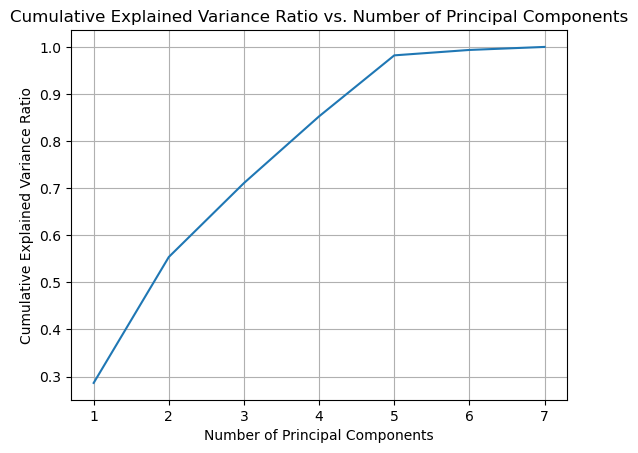

In [59]:
from sklearn.decomposition import PCA

pca_d8 = PCA()
pca_d8.fit(train_data4_scaled)

# The explained variance ratio for each principal component
explained_variance_ratio = pca_d8.explained_variance_ratio_

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(
    range(1, len(cumulative_variance_ratio) + 1),
    cumulative_variance_ratio,
)

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio vs. Number of Principal Components")
plt.grid(True)
plt.show()

### (b) Determine the number of principal components necessary to preserve at least 90% of the variance.

From the diagram above, we can see we need at least **5** principal components.

### (c) Train a Linear Regression using the selected number of principal components. Present the RSME for the training and test data

In [22]:
train_data4_pca = pca_d8.transform(train_data4_scaled)[:, :5]
test_data4_pca = pca_d8.transform(test_data4_scaled)[:, :5]

lr_d8 = LinearRegression().fit(train_data4_pca, train_target4)

lr_d8_train_rmse = root_mean_squared_error(
    train_target4, lr_d8.predict(train_data4_pca)
)
lr_d8_test_rmse = root_mean_squared_error(test_target4, lr_d8.predict(test_data4_pca))

print_markdown(f"- **Train RMSE:** {lr_d8_train_rmse}")
print_markdown(f"- **Test RMSE:** {lr_d8_test_rmse}")

- **Train RMSE:** 0.80587054076401

- **Test RMSE:** 1.3394144069946172

After performing principal component selection, the performance of the Linear Regression model on Train set droped a bit. And on the test set, the model still can't capture the underlying pattern of the data, and is underfitting.

### (d) Use GridSearchCV to find the optimal number of principal components according to a 10-fold cross-validation and use a Linear Regression as the base model.

In [61]:
from sklearn.pipeline import Pipeline

grid_search_cv_d8 = GridSearchCV(
    Pipeline([("pca", PCA()), ("lr", LinearRegression())]),
    param_grid={"pca__n_components": range(1, 8)},
    cv=KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1,
).fit(train_data4_scaled, train_target4)

best_n_components = grid_search_cv_d8.best_params_["pca__n_components"]

d8d_train_rmse = root_mean_squared_error(
    train_target4, grid_search_cv_d8.predict(train_data4_scaled)
)
d8d_test_rmse = root_mean_squared_error(
    test_target4, grid_search_cv_d8.predict(test_data4_scaled)
)

print("Best number of components:", best_n_components)
print("Train RMSE:", d8d_train_rmse)
print("Test RMSE:", d8d_test_rmse)

Best number of components: 7
Train RMSE: 0.7189383142730592
Test RMSE: 1.1783865331170065


### (e) Discuss the obtained results and compare them with the ones you obtained in D7.

In [63]:
print_markdown(f"D7 LR Train RMSE: {d3_result[1]["LR Train RMSE"]}")
print_markdown(f"D8 LR Train RMSE: {d8d_train_rmse}")
print_markdown(f"D7 LR Test RMSE: {d3_result[1]["LR Test RMSE"]}")
print_markdown(f"D8 LR Test RMSE: {d8d_test_rmse}")

D7 LR Train RMSE: 0.709490159104849

D8 LR Train RMSE: 0.7189383142730592

D7 LR Test RMSE: 1.1360103992432067

D8 LR Test RMSE: 1.1783865331170065


Comparing to the result in D7, the model we obtained above is very close the best LR model in D7. That means using 7 components can capture most of the information in the data.

# Clustering analysis.
## D9: Consider data3 without any categorical variable. Create the following clustering:
### (a) Using this data, perform a hierarchical clustering with average linkage and Euclidean distance to cluster the districts. Cut the dendrogram at a height that results in four distinct clusters. Present the mean of the variables for each cluster and briefly summarise the characteristics of the districts in the four groups, including the size of each cluster

**Again data4 is data3 without any categorical variable.**

In [24]:
from scipy.cluster.hierarchy import linkage

Z_a = linkage(data4, method="average", metric="euclidean")

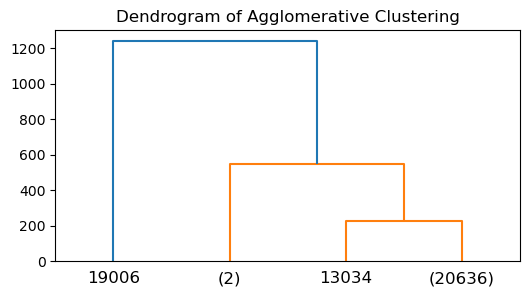

In [78]:
from scipy.cluster.hierarchy import fcluster, dendrogram

plt.figure(figsize=(6,3))
dendrogram(Z_a, 4, "lastp")
plt.title("Dendrogram of Agglomerative Clustering")
plt.show()

In [26]:
cluster_a = fcluster(
    Z_a,
    4,
    criterion="maxclust",
)

data4_cluster_a = data4.copy()
data4_cluster_a["cluster"] = cluster_a

data4_cluster_a_grouped = data4_cluster_a.groupby("cluster").mean()
data4_cluster_a_grouped["size"] = data4_cluster_a.groupby("cluster").size()
print_markdown("**Clustered data4 (a) grouped statistics:**")
print_df(data4_cluster_a_grouped.transpose())

**Clustered data4 (a) grouped statistics:**

|                        |          1 |           2 |          3 |           4 |
|:-----------------------|-----------:|------------:|-----------:|------------:|
| longitude              | -120.605   |  -119.569   | -121.15    | -121.98     |
| latitude               |   37.865   |    35.6314  |   38.69    |   38.32     |
| housingMedianAge       |   41       |    28.6364  |   52       |   45        |
| medianIncome           |    4.8909  |     3.87015 |    6.1359  |   10.2264   |
| medianHouseValue       |    2.0875  |     2.06858 |    2.25    |    1.375    |
| medianRooms            |    7.10989 |     5.42881 |    8.27586 |    3.16667  |
| medianBedrooms         |    1.22527 |     1.09666 |    1.51724 |    0.833333 |
| populationPerHousehold |  551.088   |     2.94644 |  230.172   | 1243.33     |
| size                   |    2       | 20636       |    1       |    1        |

We can notice that they have large difference on populationPerHousehold. But there are only one large cluster, let's check the data.

In [92]:
from plotly.graph_objects import Figure, Scatter3d


def visualize_cluster_reactive(data, cluster=None, title=None):
    pca = PCA()
    pca.fit(data)
    fig = Figure()
    fig.add_trace(
        Scatter3d(
            x=pca.transform(data)[:, 0],
            y=pca.transform(data)[:, 1],
            z=pca.transform(data)[:, 2],
            mode="markers",
            marker=dict(color=cluster, colorscale="Viridis", size=5, opacity=0.8),
        )
    )
    fig.update_layout(
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3",
        ),
        title=title,
    )
    fig.show()


def visualize_cluster(
    data, cluster, parent_fig_index=None, title=None, start_dim=0
):
    pca = PCA()
    pca.fit(data)
    pca_data = pca.transform(data)[:, start_dim : 3 + start_dim]
    fig = (
        plt.figure(figsize=(4, 4)) if parent_fig_index is None else parent_fig_index[0]
    )
    ax = fig.add_subplot(
        None if parent_fig_index is None else parent_fig_index[1], projection="3d"
    )
    unique_clusters = set(cluster)
    for clust in unique_clusters:
        ax.scatter(
            *pca_data[cluster == clust].transpose(),
            label=clust,
            alpha=0.8,
        )

    ax.set_xlabel(f"PC{start_dim + 1}")
    ax.set_ylabel(f"PC{start_dim + 2}")
    ax.set_zlabel(f"PC{start_dim + 3}")

    ax.legend()

    if title:
        ax.set_title(title)
    if parent_fig_index is None:
        plt.show()


def visualize_cluster_2d(data, cluster, ax=None, title=None, start_dim=0):
    pca = PCA()
    pca.fit(data)

    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot()

    unique_clusters = set(cluster)
    for clust in unique_clusters:
        ax.scatter(
                *pca.transform(data[cluster == clust])[:, start_dim : 2 + start_dim].transpose(),
                label=clust,
                alpha=0.8,
            )
    
    ax.set_xlabel(f"PC{start_dim + 1}")
    ax.set_ylabel(f"PC{start_dim + 2}")
    ax.legend()

    if title:
        ax.set_title(title)
    if ax is None:
        plt.show()

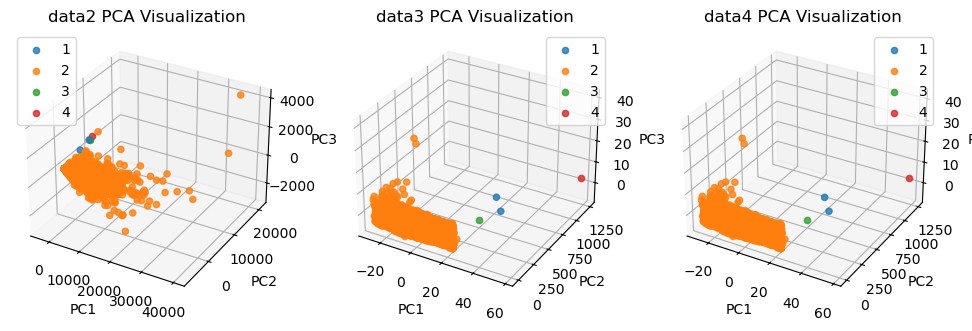

In [99]:
fig = plt.figure(figsize=(12, 4))
visualize_cluster(data2, cluster_a, (fig, 131), "data2 PCA Visualization")
visualize_cluster(data3, cluster_a, (fig, 132), "data3 PCA Visualization")
visualize_cluster(data4, cluster_a, (fig, 133), "data4 PCA Visualization")

We can seed that, after the modification in data3, the data points are compressed in a small space, which may results in the poor hierarchical clustering result.

### (b) Using standardised features, perform a hierarchical clustering with average linkage and Euclidean distance to cluster the districts. Cut the dendrogram at a height that results in four distinct clusters. Did the groups change? What effect does scaling the variables have on the hierarchical clustering obtained?

In [29]:
scaler_d9 = StandardScaler()
data4_scaled = scaler_d9.fit_transform(data4)

Z_b = linkage(data4_scaled, method="average", metric="euclidean")

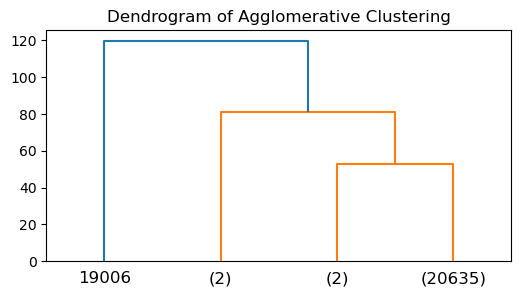

In [76]:
plt.figure(figsize=(6, 3))
dendrogram(Z_b, 4, "lastp")
plt.title("Dendrogram of Agglomerative Clustering")
plt.show()

In [31]:
cluster_b = fcluster(
    Z_b,
    4,
    criterion="maxclust",
)

data4_cluster_b = data4.copy()
data4_cluster_b["cluster"] = cluster_b

data4_cluster_b_grouped = data4_cluster_b.groupby("cluster").mean()
data4_cluster_b_grouped["size"] = data4_cluster_b.groupby("cluster").size()
print_markdown("**Clustered data4 (b) grouped statistics:**")
print_df(data4_cluster_b_grouped.transpose())

**Clustered data4 (b) grouped statistics:**

|                        |          1 |          2 |           3 |           4 |
|:-----------------------|-----------:|-----------:|------------:|------------:|
| longitude              | -120.09    | -120.605   |  -119.569   | -121.98     |
| latitude               |   38.855   |   37.865   |    35.6312  |   38.32     |
| housingMedianAge       |   33.5     |   41       |    28.637   |   45        |
| medianIncome           |    3.25    |    4.8909  |     3.87032 |   10.2264   |
| medianHouseValue       |    3.31251 |    2.0875  |     2.06847 |    1.375    |
| medianRooms            |  137.221   |    7.10989 |     5.41617 |    3.16667  |
| medianBedrooms         |   29.8515  |    1.22527 |     1.09389 |    0.833333 |
| populationPerHousehold |    2.56364 |  551.088   |     2.95748 | 1243.33     |
| size                   |    2       |    2       | 20635       |    1        |

We can see the cluster result slightly changed after scaling the variables. But since most cluster only contains a few examples, the result is not meaningful enough.

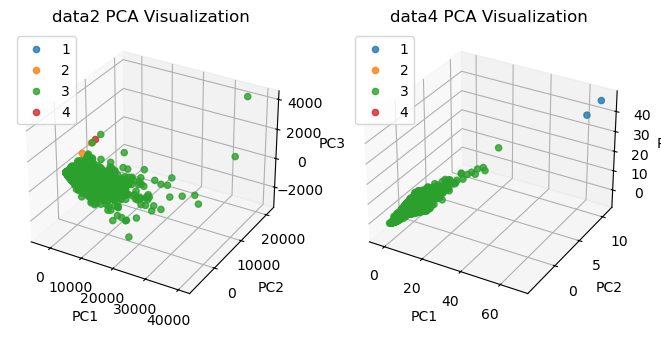

In [97]:
fig = plt.figure(figsize=(8, 4))
visualize_cluster(data2, cluster_b, (fig, 121), "data2 PCA Visualization")
visualize_cluster(data4_scaled, cluster_b, (fig, 122), "data4 PCA Visualization")

We can see that outliners in data4 feature space are more likely selected as clusters. But again, we can see that in the original data space, the clustering result is not meaningful.

### (c) Using standardised features, apply the k-means clustering (with k=4) with Euclidean distance. Set the initial centroids of the k-means as the group means obtained from the hierarchical clustering in part (b). Compare the results with the hierarchical clustering from part (b). Which one do you think provides a better result?

In [33]:
from sklearn.cluster import KMeans

centers = scaler_d9.transform(data4_cluster_b_grouped.drop(columns=["size"]))

kmeans_c = KMeans(
    n_clusters=4,
    random_state=RANDOM_SEED,
    init=centers,
)

kmeans_c.fit(data4_scaled);

In [34]:
data4_cluster_c = data4.copy()
data4_cluster_c["cluster"] = kmeans_c.labels_
cluster_c = kmeans_c.labels_
data4_cluster_c_grouped = data4_cluster_c.groupby("cluster").mean()
data4_cluster_c_grouped["size"] = data4_cluster_c.groupby("cluster").size()
print_markdown("**Clustered data4 (c) grouped statistics:**")
print_df(data4_cluster_c_grouped.transpose())

**Clustered data4 (c) grouped statistics:**

|                        |          0 |          1 |           2 |           3 |
|:-----------------------|-----------:|-----------:|------------:|------------:|
| longitude              | -120.09    | -120.605   |  -119.569   | -121.98     |
| latitude               |   38.855   |   37.865   |    35.6312  |   38.32     |
| housingMedianAge       |   33.5     |   41       |    28.637   |   45        |
| medianIncome           |    3.25    |    4.8909  |     3.87032 |   10.2264   |
| medianHouseValue       |    3.31251 |    2.0875  |     2.06847 |    1.375    |
| medianRooms            |  137.221   |    7.10989 |     5.41617 |    3.16667  |
| medianBedrooms         |   29.8515  |    1.22527 |     1.09389 |    0.833333 |
| populationPerHousehold |    2.56364 |  551.088   |     2.95748 | 1243.33     |
| size                   |    2       |    2       | 20635       |    1        |

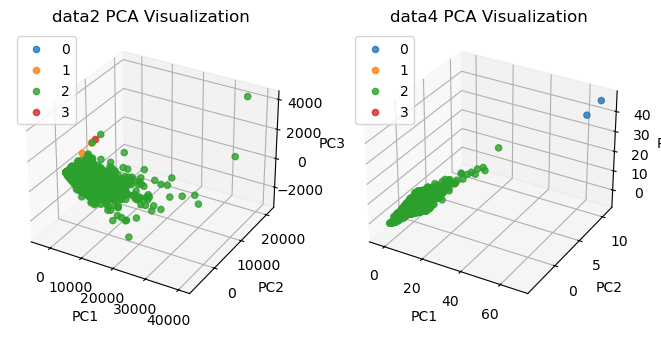

In [105]:
fig = plt.figure(figsize=(8, 4))
visualize_cluster(data2, cluster_c, (fig, 121), "data2 PCA Visualization")
visualize_cluster(data4_scaled, cluster_c, (fig, 122), "data4 PCA Visualization")

The result didn't change significantly after using the k-means clustering with the initial centroids from the hierarchical clustering. And it is not a better result.

### (d) Perform PCA on the scaled data. Perform hierarchical clustering with average linkage and Euclidean distance on the first two principal component scores. Cut the dendrogram at a height that results in four distinct clusters. Present the scatterplot of the first two principal components using different colours for the instances on each cluster (four colours for four clusters). Compare the group characteristics to the group characteristics obtained in the previous tasks.

In [36]:
pca_d9_d = PCA()
pca_d9_d.fit(data4_scaled)
data4_pca = pca_d9_d.transform(data4_scaled)

Z_d = linkage(data4_pca[:,:2], method="average", metric="euclidean")

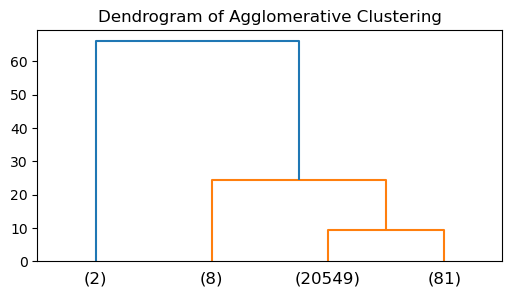

In [85]:
plt.figure(figsize=(6, 3))
dendrogram(Z_d, 4, "lastp")
plt.title("Dendrogram of Agglomerative Clustering")
plt.show()

**Clustered data4 (d) grouped statistics:**

|                        |          1 |          2 |           3 |          4 |
|:-----------------------|-----------:|-----------:|------------:|-----------:|
| longitude              | -120.09    | -119.321   |  -119.569   | -119.842   |
| latitude               |   38.855   |   38.0737  |    35.6208  |   38.1299  |
| housingMedianAge       |   33.5     |   18.375   |    28.689   |   16.963   |
| medianIncome           |    3.25    |    3.09014 |     3.87172 |    3.69688 |
| medianHouseValue       |    3.31251 |    1.74087 |     2.07041 |    1.60021 |
| medianRooms            |  137.221   |   55.5338  |     5.32292 |   24.1377  |
| medianBedrooms         |   29.8515  |   11.5372  |     1.07485 |    4.89208 |
| populationPerHousehold |    2.56364 |    2.11484 |     3.07318 |    2.53606 |
| size                   |    2       |    8       | 20549       |   81       |

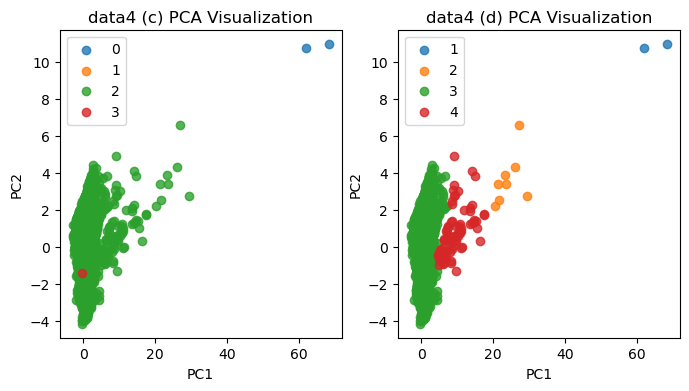

In [86]:
cluster_d = fcluster(
    Z_d,
    4,
    criterion="maxclust",
)

data4_cluster_d = data4.copy()
data4_cluster_d["cluster"] = cluster_d

data4_cluster_d_grouped = data4_cluster_d.groupby("cluster").mean()
data4_cluster_d_grouped["size"] = data4_cluster_d.groupby("cluster").size()
print_markdown("**Clustered data4 (d) grouped statistics:**")
print_df(data4_cluster_d_grouped.transpose())

figs, axes = plt.subplots(1, 2, figsize=(8, 4))
visualize_cluster_2d(data4_pca, cluster_c, title="data4 (c) PCA Visualization", ax=axes[0])
visualize_cluster_2d(data4_pca, cluster_d, title="data4 (d) PCA Visualization", ax=axes[1])


Now the result is more meaningful, we can see the four clusters are more separated in the PCA space. Also, the mean of the variables for each cluster is more significant spread out. Compared to the previous tasks, the imbalance of the cluster size is slightly improved, but still a problem.

### (e) Perform PCA on the scaled data. Apply the k-means clustering (with k=4) with Euclidean distance on the first two principal component scores, setting the random state to “5508”. Present the scatterplot of the first two principal components using different colours for the instances on each cluster (four colours for four clusters). Discuss the results.

**Clustered data4 (e) grouped statistics:**

|                        |          0 |          1 |          2 |          3 |
|:-----------------------|-----------:|-----------:|-----------:|-----------:|
| longitude              | -117.973   | -121.657   | -119.735   | -118.728   |
| latitude               |   33.9087  |   37.925   |   38.1144  |   34.5749  |
| housingMedianAge       |   29.6321  |   29.116   |   17.6389  |   24.0717  |
| medianIncome           |    3.2968  |    3.48366 |    3.38408 |    6.92731 |
| medianHouseValue       |    1.82367 |    1.80268 |    1.72156 |    3.67161 |
| medianRooms            |    4.75693 |    5.33984 |   43.1896  |    7.44825 |
| medianBedrooms         |    1.05668 |    1.07684 |    9.00404 |    1.18769 |
| populationPerHousehold |    3.10445 |    3.05563 |    2.26906 |    3.01267 |
| size                   | 9424       | 8348       |   36       | 2832       |

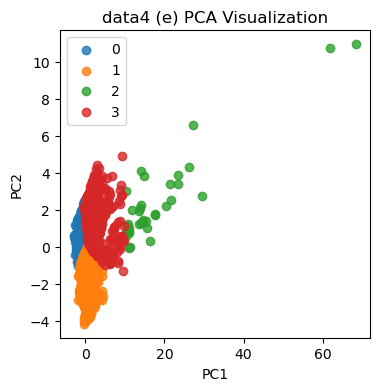

In [103]:
kmeans_e = KMeans(
    n_clusters=4,
    random_state=RANDOM_SEED,
)

kmeans_e.fit(data4_pca[:,:2])
cluster_e = kmeans_e.labels_

data4_cluster_e = data4.copy()
data4_cluster_e["cluster"] = cluster_e

data4_cluster_e_grouped = data4_cluster_e.groupby("cluster").mean()
data4_cluster_e_grouped["size"] = data4_cluster_e.groupby("cluster").size()
print_markdown("**Clustered data4 (e) grouped statistics:**")
print_df(data4_cluster_e_grouped.transpose())

visualize_cluster_2d(data4_pca, cluster_e, title="data4 (e) PCA Visualization")

With random select initial centroids, the result is more balanced than the previous task. In the PCA space, considering the problem of medianHouseValue, we can see that cluster 3 has the highest mean medianHouseValue, and the rest of the clusters have similar mean medianHouseValue.

## D10: Consider data3 without any categorical variable. Compute the silhouette score by applying k-means on this dataset after scaling the features to have zero mean and unit standard deviation.

### (a) Plot the silhouette scores for the different k values. According to this score, what was the optimal value of clustering?

In [40]:
from sklearn.metrics import silhouette_score

silhouettes = []
for k in range(2,20,1):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(data4_scaled)
    silhouettes.append(silhouette_score(data4_scaled, kmeans.labels_))

- **Best number of clusters:** 4

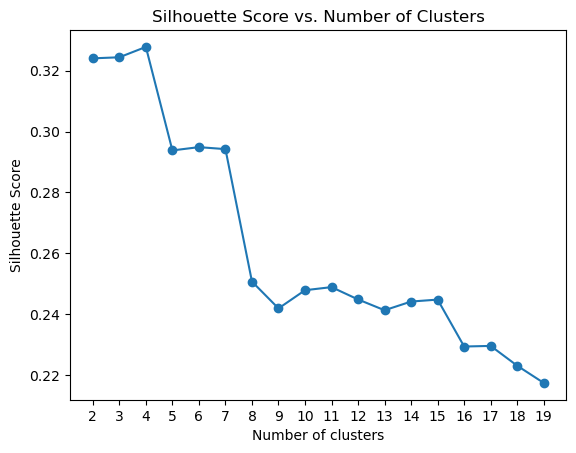

In [41]:
print_markdown(f"- **Best number of clusters:** {np.argmax(silhouettes) + 2}")
plt.plot(range(2,20,1), silhouettes, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2,20,1))
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

### (b) Considering the optimal k value obtained in the previous item, plot the k groups (using different colours for the instances in each group) on the first two principal component scores of the same data. In a side plot, plot the first principal component scores in which the instance colours represent the values of the categorical value you discarded for this part of the assignment. Comment on the relationship between the groups in these two plots.

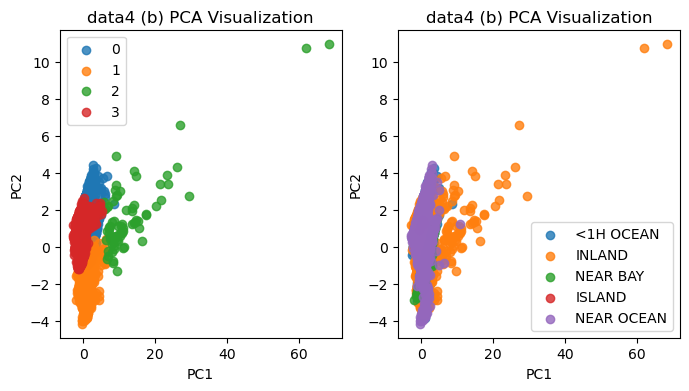

In [106]:
kmeans_d10_b = KMeans(n_clusters=4, random_state=RANDOM_SEED)
kmeans_d10_b.fit_predict(data4_scaled)

kmeans_d10_b_cluster = kmeans_d10_b.labels_

figs, axes = plt.subplots(1, 2, figsize=(8, 4))

visualize_cluster_2d(data4_scaled, kmeans_d10_b_cluster, title="data4 (b) PCA Visualization", ax=axes[0])
visualize_cluster_2d(data4_scaled, data0["oceanProximity"], title="data4 (b) PCA Visualization", ax=axes[1])


From the diagram we can see cluster 2 is overlap with INLAND houses to a large extent. We might guess cluster 2 successfully learn the information of INLAND houses.

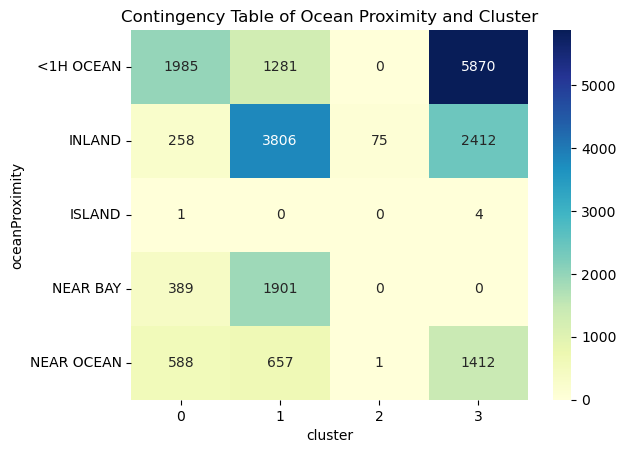

In [133]:
import seaborn as sns

df = pd.DataFrame({
    "cluster": kmeans_d10_b_cluster,
    "oceanProximity": data0["oceanProximity"].values
})

cross_tab = pd.crosstab( df['oceanProximity'],df['cluster'])
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Contingency Table of Ocean Proximity and Cluster')
plt.show()

On the diagram we could see the most significant relationship between the groups is cluster 3 and <1H OCEAN. But overall relationship between the groups is not very strong.

### (c) With clustering analysis and your findings from EDA, what are your conclusions about the data that may be impacting your models?

- Based on the work of finding the optimal alpha, we knows that scaling the target variable might heavily impact the hyperparameters of the model. Also the same hyperparameter could have different optimal value on different model due to the different objective function.